In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Data = pd.read_csv('Churn_Modelling.csv')
Data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
###Remove Unwanted Features
Churn = Data.copy()
Churn = Churn.drop(['RowNumber','CustomerId','Surname'],axis=1)
Churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Converting Categorical Features

In [4]:
Churn.dtypes[Churn.dtypes == object]

Geography    object
Gender       object
dtype: object

In [5]:
Churn['Geography'] = Churn['Geography'].astype('category').cat.codes
Churn['Gender'] = Churn['Gender'].astype('category').cat.codes

In [6]:
Churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df = Churn.copy()

In [8]:
from sklearn.preprocessing import minmax_scale, StandardScaler
clm = ((df.dtypes!="object")).index
clm

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [37]:
Stsc = StandardScaler().fit_transform(df[clm].drop('Exited',axis=1))
d  = pd.DataFrame(Stsc,columns=clm.drop('Exited'))
df = pd.concat([d,df['Exited']],axis=1)

## Building a Naiive Bayes Model

In [38]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def NBClassifer(X_train,X_test,y_train,y_test,thrshld=0.5):
    '''
    X_train, y_train are training data sets
    X_test, y_test are testing data sets
    '''
    
    
    NB_classifier = GaussianNB()
    NB_classifier.fit(X_train,y_train)
    logical = NB_classifier.predict_proba(X_test)[:,1]>thrshld
    pred = [0]*np.size(logical)
    for i in np.arange(0,np.size(logical)):
        if logical[i]==True:
            pred[i]=1
    cm = confusion_matrix(y_test,pred)
    print('\n Confusion Matrix: \n',cm)
    cr = classification_report(y_test,pred)
    print('\n classification report: \n ',cr)
    NB_roc_auc = roc_auc_score(y_test,pred)
    print('\n ROC Score: \n',NB_roc_auc)
    print('--'*50)

    fpr, tpr, thresholds = roc_curve(y_test,NB_classifier.predict_proba(X_test)[:,1])
    plt.plot(fpr,tpr ,label='NB classifier (area = %0.2f)' % NB_roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc='lower right')
    plt.grid()
    return 

In [39]:
def NB_Kfold(df,target, k, thrshld=0.5):
    '''
    df : Data Frame
    target : target varible
    k =number of folds
    threshold = default 0.5
    '''
    X = df.drop(target,axis=1)
    y = df[target]
    
    if k==1:
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,random_state=101)
        NBClassifer(X_train, X_test, y_train, y_test,thrshld=thrshld)
    else:
        kf = KFold(n_splits=k,random_state=1,shuffle=True)
        for train,test in kf.split(df):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            NBClassifer(X_train, X_test, y_train, y_test,thrshld=thrshld)
         
    plt.show()
        
    return 


 Confusion Matrix: 
 [[2605   34]
 [ 539  156]]

 classification report: 
                precision    recall  f1-score   support

           0       0.83      0.99      0.90      2639
           1       0.82      0.22      0.35       695

    accuracy                           0.83      3334
   macro avg       0.82      0.61      0.63      3334
weighted avg       0.83      0.83      0.79      3334


 ROC Score: 
 0.6057883817992973
----------------------------------------------------------------------------------------------------

 Confusion Matrix: 
 [[2601   46]
 [ 529  157]]

 classification report: 
                precision    recall  f1-score   support

           0       0.83      0.98      0.90      2647
           1       0.77      0.23      0.35       686

    accuracy                           0.83      3333
   macro avg       0.80      0.61      0.63      3333
weighted avg       0.82      0.83      0.79      3333


 ROC Score: 
 0.6057424049008668
-----------------------

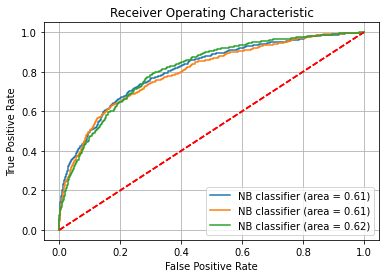

In [43]:
NB_Kfold(df=df,target='Exited',k=3,thrshld=0.5)